In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
np.random.seed(777)
import math
import keras
import keras.backend as K
import h5py
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Activation, merge, Dense, Flatten, Dropout, concatenate
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, add, GlobalAveragePooling2D
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score
from keras.regularizers import l2
from keras.applications.xception import Xception, preprocess_input
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications import DenseNet201
from keras.applications import DenseNet121

from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Lambda,Concatenate
from keras.layers import SeparableConv2D, AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Add

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

Using TensorFlow backend.


In [3]:
train_dir = 'data/bioimaging/train/'
test_dir = "data/bioimaging/test/"

extracted_features_dir = "extracted_features/"
model_name = "bioimaging_VGG16"

In [4]:
import keras
import tensorflow as tf
import keras.backend as K

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.2.4
tensorflow Version 1.10.0
dim_ordering: tf


In [5]:
batch_size = 32
img_height, img_width = 224, 224
input_shape = (img_height, img_width, 3)
epochs = 1000

In [6]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

print("*"*30)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))

data/bioimaging/train/ 0
data/bioimaging/train/carcinoma 5696
data/bioimaging/train/non-carcinoma 5696
******************************
data/bioimaging/test/ 0
data/bioimaging/test/carcinoma 36
data/bioimaging/test/non-carcinoma 35


In [7]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    validation_split= 0.25,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 8544 images belonging to 2 classes.
Found 2848 images belonging to 2 classes.
Found 71 images belonging to 2 classes.


In [8]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))

nb_test_samples = len(test_generator.filenames)
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

# nb_test_without_aug_samples = len(test_generator_without_aug.filenames)
# predict_size_test_without_aug = int(math.ceil(nb_test_without_aug_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
# print("nb_test_without_aug_samples:", nb_test_without_aug_samples)
# print("predict_size_test_without_aug_samples:", predict_size_test_without_aug)
print("nb_test_samples:", nb_test_samples)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 8544
nb_validation_samples: 2848

predict_size_train: 267
predict_size_validation: 89
nb_test_samples: 71
predict_size_test: 3

 num_classes: 2


In [9]:
# from keras.backend.tensorflow_backend import get_session
# from keras.backend.tensorflow_backend import clear_session
# from keras.backend.tensorflow_backend import set_session

# def reset_keras_tf_session():
#     """
#     this function clears the gpu memory and set the 
#     tf session to not use the whole gpu
#     """
#     sess = get_session()
#     clear_session()
#     sess.close()
#     sess = get_session()

# #     config = tf.ConfigProto()
# #     config.gpu_options.allow_growth = True
# #     set_session(tf.Session(config=config))


# reset_keras_tf_session()

In [10]:
# from keras.applications.mobilenetv2 import MobileNetV2
# from keras.applications.densenet import DenseNet169
# from keras.applications.vgg19 import VGG19
# from keras.applications.inception_v3 import InceptionV3
# from keras.applications.vgg16 import VGG16
# from keras.applications.xception import Xception, preprocess_input
# from keras.applications import DenseNet201
# from keras.applications import DenseNet121
# from keras.applications import ResNet50
# from keras.applications.inception_resnet_v2 import InceptionResNetV2
# from keras.applications import NASNetLarge, NASNetMobile
# from keras.applications import MobileNet


input_tensor = Input(shape = input_shape)  
model = VGG16(weights='imagenet', include_top=False, pooling = 'avg', input_tensor=input_tensor)
bottleneck_final_model = model

In [11]:
# for i, layer in enumerate(model.layers):
#     print(i, layer.name)

In [12]:
# c1 = model.layers[9].output 
# c1 = GlobalAveragePooling2D()(c1)       

# c2 = model.layers[55].output
# c2 = GlobalAveragePooling2D()(c2)       

# c3 = model.layers[143].output
# c3 = GlobalAveragePooling2D()(c3)       

# c4 = model.layers[483].output
# c4 = GlobalAveragePooling2D()(c4)

# con = concatenate([c1, c2, c3, c4])

# bottleneck_final_model = Model(inputs=model.input, outputs=con)

In [13]:
# bottleneck_final_model.summary()

In [14]:
bottleneck_features_train = bottleneck_final_model.predict_generator(train_generator, predict_size_train)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

In [15]:
bottleneck_features_validation = bottleneck_final_model.predict_generator(validation_generator, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

bottleneck_features_test = bottleneck_final_model.predict_generator(test_generator, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [16]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [17]:
dropout_rate = 0.4

model = Sequential()
# model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(num_classes, activation=tf.nn.softmax))

adam_opt2=Adam(lr = 0.0001, beta_1=0.6, beta_2=0.9, amsgrad=False)

model.compile(optimizer=adam_opt2, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)

with open(extracted_features_dir+'history_'+model_name+'.txt','w') as f:
    f.write(str(history.history))

# model.save_weights(top_model_weights_path)
# model.save(top_model_path)

Train on 8544 samples, validate on 2848 samples
Epoch 1/1000
 - 1s - loss: 0.6644 - acc: 0.5975 - val_loss: 0.5582 - val_acc: 0.7486
Epoch 2/1000
 - 1s - loss: 0.5502 - acc: 0.7246 - val_loss: 0.5017 - val_acc: 0.7739
Epoch 3/1000
 - 1s - loss: 0.5029 - acc: 0.7569 - val_loss: 0.4670 - val_acc: 0.7928
Epoch 4/1000
 - 1s - loss: 0.4703 - acc: 0.7825 - val_loss: 0.4450 - val_acc: 0.8006
Epoch 5/1000
 - 1s - loss: 0.4451 - acc: 0.7981 - val_loss: 0.4225 - val_acc: 0.8171
Epoch 6/1000
 - 1s - loss: 0.4247 - acc: 0.8100 - val_loss: 0.4015 - val_acc: 0.8294
Epoch 7/1000
 - 1s - loss: 0.4062 - acc: 0.8207 - val_loss: 0.3861 - val_acc: 0.8339
Epoch 8/1000
 - 1s - loss: 0.3958 - acc: 0.8267 - val_loss: 0.3726 - val_acc: 0.8438
Epoch 9/1000
 - 1s - loss: 0.3812 - acc: 0.8379 - val_loss: 0.3593 - val_acc: 0.8434
Epoch 10/1000
 - 1s - loss: 0.3651 - acc: 0.8421 - val_loss: 0.3508 - val_acc: 0.8501
Epoch 11/1000
 - 1s - loss: 0.3535 - acc: 0.8508 - val_loss: 0.3380 - val_acc: 0.8574
Epoch 12/1000
 

Epoch 96/1000
 - 1s - loss: 0.0385 - acc: 0.9910 - val_loss: 0.0521 - val_acc: 0.9856
Epoch 97/1000
 - 1s - loss: 0.0371 - acc: 0.9904 - val_loss: 0.0546 - val_acc: 0.9838
Epoch 98/1000
 - 1s - loss: 0.0351 - acc: 0.9912 - val_loss: 0.0520 - val_acc: 0.9846
Epoch 99/1000
 - 1s - loss: 0.0374 - acc: 0.9904 - val_loss: 0.0517 - val_acc: 0.9846
Epoch 100/1000
 - 1s - loss: 0.0353 - acc: 0.9909 - val_loss: 0.0536 - val_acc: 0.9842
Epoch 101/1000
 - 1s - loss: 0.0363 - acc: 0.9899 - val_loss: 0.0490 - val_acc: 0.9867
Epoch 102/1000
 - 1s - loss: 0.0367 - acc: 0.9903 - val_loss: 0.0554 - val_acc: 0.9800
Epoch 103/1000
 - 1s - loss: 0.0323 - acc: 0.9923 - val_loss: 0.0483 - val_acc: 0.9870
Epoch 104/1000
 - 1s - loss: 0.0345 - acc: 0.9918 - val_loss: 0.0479 - val_acc: 0.9867
Epoch 105/1000
 - 1s - loss: 0.0336 - acc: 0.9906 - val_loss: 0.0467 - val_acc: 0.9863
Epoch 106/1000
 - 1s - loss: 0.0311 - acc: 0.9923 - val_loss: 0.0471 - val_acc: 0.9856
Epoch 107/1000
 - 1s - loss: 0.0308 - acc: 0.99

Epoch 191/1000
 - 1s - loss: 0.0082 - acc: 0.9988 - val_loss: 0.0288 - val_acc: 0.9919
Epoch 192/1000
 - 1s - loss: 0.0095 - acc: 0.9977 - val_loss: 0.0286 - val_acc: 0.9902
Epoch 193/1000
 - 1s - loss: 0.0083 - acc: 0.9979 - val_loss: 0.0289 - val_acc: 0.9905
Epoch 194/1000
 - 1s - loss: 0.0084 - acc: 0.9979 - val_loss: 0.0273 - val_acc: 0.9919
Epoch 195/1000
 - 1s - loss: 0.0087 - acc: 0.9981 - val_loss: 0.0281 - val_acc: 0.9905
Epoch 196/1000
 - 1s - loss: 0.0078 - acc: 0.9984 - val_loss: 0.0290 - val_acc: 0.9909
Epoch 197/1000
 - 1s - loss: 0.0079 - acc: 0.9985 - val_loss: 0.0362 - val_acc: 0.9877
Epoch 198/1000
 - 1s - loss: 0.0081 - acc: 0.9984 - val_loss: 0.0289 - val_acc: 0.9912
Epoch 199/1000
 - 1s - loss: 0.0066 - acc: 0.9993 - val_loss: 0.0284 - val_acc: 0.9909
Epoch 200/1000
 - 1s - loss: 0.0078 - acc: 0.9982 - val_loss: 0.0281 - val_acc: 0.9919
Epoch 201/1000
 - 1s - loss: 0.0073 - acc: 0.9982 - val_loss: 0.0263 - val_acc: 0.9926
Epoch 202/1000
 - 1s - loss: 0.0070 - acc: 

 - 1s - loss: 0.0037 - acc: 0.9994 - val_loss: 0.0249 - val_acc: 0.9937
Epoch 286/1000
 - 1s - loss: 0.0031 - acc: 0.9989 - val_loss: 0.0251 - val_acc: 0.9937
Epoch 287/1000
 - 1s - loss: 0.0038 - acc: 0.9988 - val_loss: 0.0260 - val_acc: 0.9933
Epoch 288/1000
 - 1s - loss: 0.0023 - acc: 0.9996 - val_loss: 0.0243 - val_acc: 0.9933
Epoch 289/1000
 - 1s - loss: 0.0028 - acc: 0.9994 - val_loss: 0.0257 - val_acc: 0.9923
Epoch 290/1000
 - 1s - loss: 0.0034 - acc: 0.9994 - val_loss: 0.0233 - val_acc: 0.9937
Epoch 291/1000
 - 1s - loss: 0.0028 - acc: 0.9995 - val_loss: 0.0246 - val_acc: 0.9933
Epoch 292/1000
 - 1s - loss: 0.0028 - acc: 0.9995 - val_loss: 0.0267 - val_acc: 0.9926
Epoch 293/1000
 - 1s - loss: 0.0032 - acc: 0.9991 - val_loss: 0.0242 - val_acc: 0.9937
Epoch 294/1000
 - 1s - loss: 0.0027 - acc: 0.9995 - val_loss: 0.0249 - val_acc: 0.9926
Epoch 295/1000
 - 1s - loss: 0.0030 - acc: 0.9993 - val_loss: 0.0273 - val_acc: 0.9923
Epoch 296/1000
 - 1s - loss: 0.0034 - acc: 0.9992 - val_lo

Epoch 380/1000
 - 1s - loss: 0.0019 - acc: 0.9995 - val_loss: 0.0295 - val_acc: 0.9916
Epoch 381/1000
 - 1s - loss: 0.0018 - acc: 0.9999 - val_loss: 0.0246 - val_acc: 0.9940
Epoch 382/1000
 - 1s - loss: 0.0020 - acc: 0.9996 - val_loss: 0.0245 - val_acc: 0.9926
Epoch 383/1000
 - 1s - loss: 0.0020 - acc: 0.9994 - val_loss: 0.0239 - val_acc: 0.9930
Epoch 384/1000
 - 1s - loss: 0.0017 - acc: 0.9995 - val_loss: 0.0261 - val_acc: 0.9933
Epoch 385/1000
 - 1s - loss: 0.0014 - acc: 0.9995 - val_loss: 0.0240 - val_acc: 0.9933
Epoch 386/1000
 - 1s - loss: 0.0031 - acc: 0.9992 - val_loss: 0.0243 - val_acc: 0.9937
Epoch 387/1000
 - 1s - loss: 0.0015 - acc: 0.9995 - val_loss: 0.0248 - val_acc: 0.9926
Epoch 388/1000
 - 1s - loss: 0.0014 - acc: 0.9996 - val_loss: 0.0259 - val_acc: 0.9926
Epoch 389/1000
 - 1s - loss: 0.0023 - acc: 0.9998 - val_loss: 0.0275 - val_acc: 0.9933
Epoch 390/1000
 - 1s - loss: 0.0018 - acc: 0.9995 - val_loss: 0.0253 - val_acc: 0.9930
Epoch 391/1000
 - 1s - loss: 0.0012 - acc: 

Epoch 474/1000
 - 1s - loss: 7.9410e-04 - acc: 0.9998 - val_loss: 0.0245 - val_acc: 0.9944
Epoch 475/1000
 - 1s - loss: 0.0011 - acc: 0.9996 - val_loss: 0.0256 - val_acc: 0.9930
Epoch 476/1000
 - 1s - loss: 7.6323e-04 - acc: 0.9999 - val_loss: 0.0261 - val_acc: 0.9937
Epoch 477/1000
 - 1s - loss: 7.6783e-04 - acc: 0.9998 - val_loss: 0.0251 - val_acc: 0.9947
Epoch 478/1000
 - 1s - loss: 0.0016 - acc: 0.9996 - val_loss: 0.0285 - val_acc: 0.9933
Epoch 479/1000
 - 1s - loss: 0.0019 - acc: 0.9993 - val_loss: 0.0238 - val_acc: 0.9944
Epoch 480/1000
 - 1s - loss: 0.0011 - acc: 0.9998 - val_loss: 0.0266 - val_acc: 0.9937
Epoch 481/1000
 - 1s - loss: 6.5390e-04 - acc: 0.9999 - val_loss: 0.0257 - val_acc: 0.9944
Epoch 482/1000
 - 1s - loss: 0.0020 - acc: 0.9994 - val_loss: 0.0250 - val_acc: 0.9940
Epoch 483/1000
 - 1s - loss: 9.7487e-04 - acc: 0.9998 - val_loss: 0.0251 - val_acc: 0.9937
Epoch 484/1000
 - 1s - loss: 0.0013 - acc: 0.9998 - val_loss: 0.0251 - val_acc: 0.9930
Epoch 485/1000
 - 1s - 

Epoch 566/1000
 - 1s - loss: 4.6917e-04 - acc: 0.9999 - val_loss: 0.0255 - val_acc: 0.9951
Epoch 567/1000
 - 1s - loss: 6.5267e-04 - acc: 1.0000 - val_loss: 0.0245 - val_acc: 0.9937
Epoch 568/1000
 - 1s - loss: 3.5888e-04 - acc: 1.0000 - val_loss: 0.0301 - val_acc: 0.9937
Epoch 569/1000
 - 1s - loss: 6.5136e-04 - acc: 0.9999 - val_loss: 0.0253 - val_acc: 0.9944
Epoch 570/1000
 - 1s - loss: 0.0014 - acc: 0.9994 - val_loss: 0.0272 - val_acc: 0.9940
Epoch 571/1000
 - 1s - loss: 7.9685e-04 - acc: 0.9999 - val_loss: 0.0309 - val_acc: 0.9937
Epoch 572/1000
 - 1s - loss: 5.1602e-04 - acc: 0.9999 - val_loss: 0.0280 - val_acc: 0.9940
Epoch 573/1000
 - 1s - loss: 8.7347e-04 - acc: 0.9995 - val_loss: 0.0263 - val_acc: 0.9951
Epoch 574/1000
 - 1s - loss: 6.6382e-04 - acc: 0.9999 - val_loss: 0.0263 - val_acc: 0.9944
Epoch 575/1000
 - 1s - loss: 0.0010 - acc: 0.9996 - val_loss: 0.0268 - val_acc: 0.9940
Epoch 576/1000
 - 1s - loss: 3.7989e-04 - acc: 1.0000 - val_loss: 0.0266 - val_acc: 0.9933
Epoch 5

Epoch 657/1000
 - 1s - loss: 7.2564e-04 - acc: 0.9998 - val_loss: 0.0274 - val_acc: 0.9947
Epoch 658/1000
 - 1s - loss: 5.6976e-04 - acc: 0.9999 - val_loss: 0.0260 - val_acc: 0.9947
Epoch 659/1000
 - 1s - loss: 2.4756e-04 - acc: 1.0000 - val_loss: 0.0285 - val_acc: 0.9944
Epoch 660/1000
 - 1s - loss: 3.1454e-04 - acc: 0.9999 - val_loss: 0.0275 - val_acc: 0.9944
Epoch 661/1000
 - 1s - loss: 9.6685e-04 - acc: 0.9998 - val_loss: 0.0265 - val_acc: 0.9940
Epoch 662/1000
 - 1s - loss: 0.0012 - acc: 0.9996 - val_loss: 0.0276 - val_acc: 0.9947
Epoch 663/1000
 - 1s - loss: 4.2721e-04 - acc: 0.9999 - val_loss: 0.0260 - val_acc: 0.9944
Epoch 664/1000
 - 1s - loss: 4.5904e-04 - acc: 0.9999 - val_loss: 0.0295 - val_acc: 0.9937
Epoch 665/1000
 - 1s - loss: 8.0314e-04 - acc: 0.9998 - val_loss: 0.0265 - val_acc: 0.9954
Epoch 666/1000
 - 1s - loss: 0.0012 - acc: 0.9999 - val_loss: 0.0300 - val_acc: 0.9947
Epoch 667/1000
 - 1s - loss: 2.1343e-04 - acc: 1.0000 - val_loss: 0.0295 - val_acc: 0.9940
Epoch 6

Epoch 748/1000
 - 1s - loss: 9.1268e-05 - acc: 1.0000 - val_loss: 0.0294 - val_acc: 0.9947
Epoch 749/1000
 - 1s - loss: 3.5692e-04 - acc: 0.9999 - val_loss: 0.0309 - val_acc: 0.9937
Epoch 750/1000
 - 1s - loss: 5.1565e-04 - acc: 0.9998 - val_loss: 0.0297 - val_acc: 0.9944
Epoch 751/1000
 - 1s - loss: 7.2991e-04 - acc: 0.9999 - val_loss: 0.0279 - val_acc: 0.9958
Epoch 752/1000
 - 1s - loss: 3.2049e-04 - acc: 0.9999 - val_loss: 0.0288 - val_acc: 0.9947
Epoch 753/1000
 - 1s - loss: 0.0016 - acc: 0.9998 - val_loss: 0.0276 - val_acc: 0.9937
Epoch 754/1000
 - 1s - loss: 6.8233e-04 - acc: 0.9999 - val_loss: 0.0289 - val_acc: 0.9951
Epoch 755/1000
 - 1s - loss: 5.8434e-04 - acc: 0.9998 - val_loss: 0.0271 - val_acc: 0.9947
Epoch 756/1000
 - 1s - loss: 5.6180e-04 - acc: 0.9998 - val_loss: 0.0287 - val_acc: 0.9944
Epoch 757/1000
 - 1s - loss: 6.1470e-04 - acc: 0.9998 - val_loss: 0.0298 - val_acc: 0.9940
Epoch 758/1000
 - 1s - loss: 1.4272e-04 - acc: 1.0000 - val_loss: 0.0273 - val_acc: 0.9940
Epo

Epoch 839/1000
 - 1s - loss: 2.3977e-04 - acc: 0.9999 - val_loss: 0.0320 - val_acc: 0.9944
Epoch 840/1000
 - 1s - loss: 0.0020 - acc: 0.9995 - val_loss: 0.0299 - val_acc: 0.9937
Epoch 841/1000
 - 1s - loss: 1.6767e-04 - acc: 1.0000 - val_loss: 0.0274 - val_acc: 0.9951
Epoch 842/1000
 - 1s - loss: 1.0759e-04 - acc: 1.0000 - val_loss: 0.0285 - val_acc: 0.9954
Epoch 843/1000
 - 1s - loss: 2.7192e-04 - acc: 0.9999 - val_loss: 0.0341 - val_acc: 0.9930
Epoch 844/1000
 - 1s - loss: 1.6573e-04 - acc: 1.0000 - val_loss: 0.0287 - val_acc: 0.9944
Epoch 845/1000
 - 1s - loss: 5.7457e-04 - acc: 0.9998 - val_loss: 0.0308 - val_acc: 0.9944
Epoch 846/1000
 - 1s - loss: 3.9861e-04 - acc: 0.9998 - val_loss: 0.0273 - val_acc: 0.9947
Epoch 847/1000
 - 1s - loss: 7.9395e-04 - acc: 0.9999 - val_loss: 0.0313 - val_acc: 0.9944
Epoch 848/1000
 - 1s - loss: 0.0013 - acc: 0.9999 - val_loss: 0.0300 - val_acc: 0.9940
Epoch 849/1000
 - 1s - loss: 1.6613e-04 - acc: 1.0000 - val_loss: 0.0292 - val_acc: 0.9944
Epoch 8

Epoch 930/1000
 - 1s - loss: 9.2380e-05 - acc: 1.0000 - val_loss: 0.0289 - val_acc: 0.9947
Epoch 931/1000
 - 1s - loss: 4.7923e-04 - acc: 0.9998 - val_loss: 0.0297 - val_acc: 0.9958
Epoch 932/1000
 - 1s - loss: 4.5969e-04 - acc: 0.9998 - val_loss: 0.0283 - val_acc: 0.9947
Epoch 933/1000
 - 1s - loss: 1.7319e-04 - acc: 0.9999 - val_loss: 0.0290 - val_acc: 0.9944
Epoch 934/1000
 - 1s - loss: 7.1904e-04 - acc: 0.9998 - val_loss: 0.0299 - val_acc: 0.9947
Epoch 935/1000
 - 1s - loss: 5.1377e-05 - acc: 1.0000 - val_loss: 0.0276 - val_acc: 0.9954
Epoch 936/1000
 - 1s - loss: 0.0010 - acc: 0.9998 - val_loss: 0.0255 - val_acc: 0.9954
Epoch 937/1000
 - 1s - loss: 1.2837e-04 - acc: 1.0000 - val_loss: 0.0289 - val_acc: 0.9947
Epoch 938/1000
 - 1s - loss: 9.2508e-05 - acc: 1.0000 - val_loss: 0.0282 - val_acc: 0.9958
Epoch 939/1000
 - 1s - loss: 8.3211e-05 - acc: 1.0000 - val_loss: 0.0300 - val_acc: 0.9947
Epoch 940/1000
 - 1s - loss: 8.2811e-04 - acc: 0.9998 - val_loss: 0.0286 - val_acc: 0.9947
Epo

In [18]:
preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.8309859154929577


Confusion Matrix
[[29  7]
 [ 5 30]]


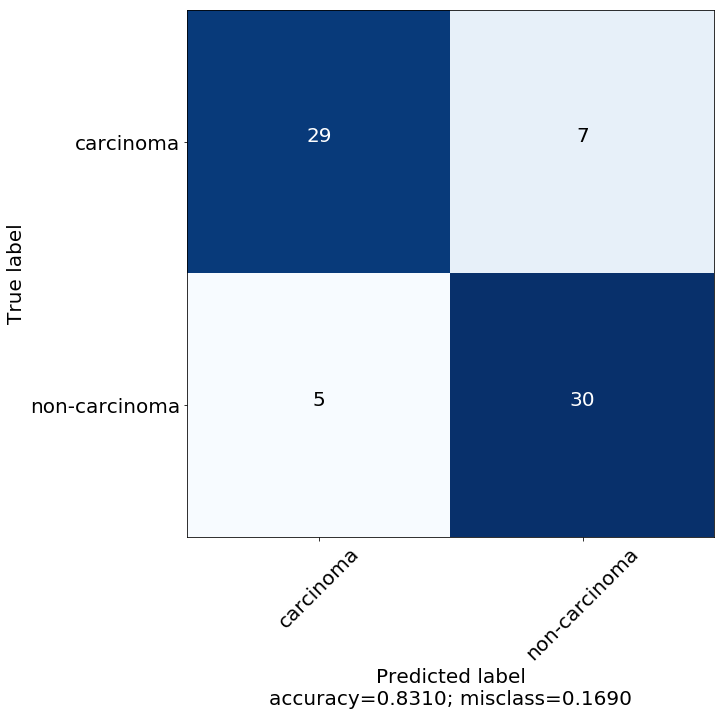

In [19]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [20]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[29  7]
 [ 5 30]]
               precision    recall  f1-score   support

    carcinoma       0.85      0.81      0.83        36
non-carcinoma       0.81      0.86      0.83        35

  avg / total       0.83      0.83      0.83        71



In [21]:
total=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Sensitivity :  85.29411764705883
Specificity :  81.08108108108108


In [22]:
print('roc_auc_score = ' + str(roc_auc_score(predictions, y_true)))

roc_auc_score = 0.8318759936406995


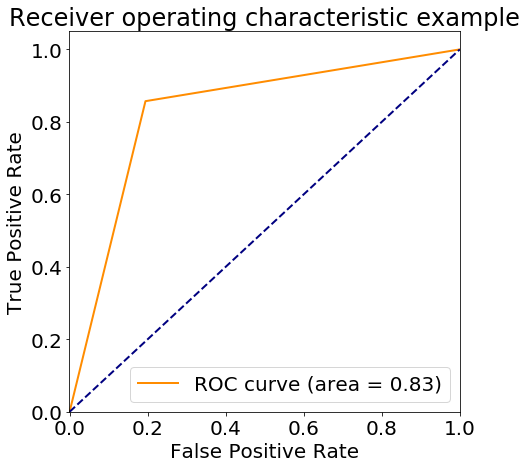

In [23]:
fpr, tpr, thresholds = roc_curve(y_true, predictions)
roc_auc = auc(fpr,tpr)

plt.figure(figsize=(7,7))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-.001, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [24]:
predict = model.predict_proba(test_data, batch_size=batch_size, verbose=1)

71/71 [==============================] - 0s 0us/step


In [25]:
from sklearn.preprocessing import label_binarize

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
y = label_binarize(test_labels, classes=[0, 1])
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], predict[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), predict.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [26]:
from scipy import interp
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

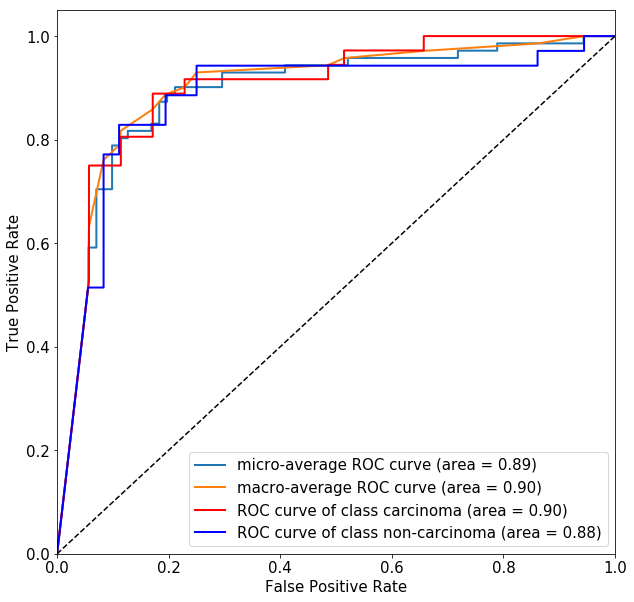

In [27]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 15})

from itertools import cycle
classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)
    

plt.figure(figsize=(10, 10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),linewidth=2)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         linewidth=2)
plot_name = 'no variation'
colors = cycle(['red','blue','green','yellow','orange', 'aqua', 'cornflowerblue'])

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classnames[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [28]:
tn, fp, fn, tp = cm.ravel()

In [29]:
print("Accuracy:",(tp+tn)/(tp+tn+fp+fn))
print("Precision:",(tp/(tp+fp)))
print("Recall:",(tp/(tp+fn)))
print("tp:", tp) 
print("fp:", fp) 
print("tn:",tn) 
print("fn:",fn)

Accuracy: 0.8309859154929577
Precision: 0.8108108108108109
Recall: 0.8571428571428571
tp: 30
fp: 7
tn: 29
fn: 5


In [30]:
print('F1 score:', f1_score(y_true, y_pred))

F1 score: 0.8333333333333334


In [31]:
recall = (tp/(tp+fn))
precision=(tp/(tp+fp))

f1 = 2 / ( (1/recall) + (1 / precision))
print('F1 score:', f1)

F1 score: 0.8333333333333334


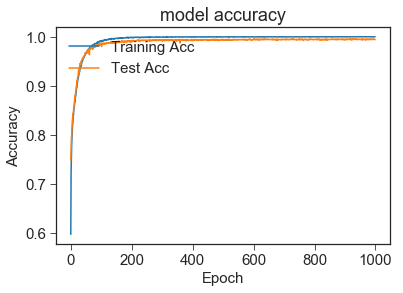

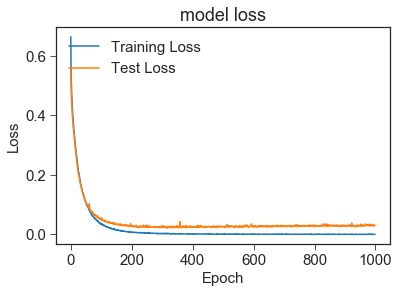

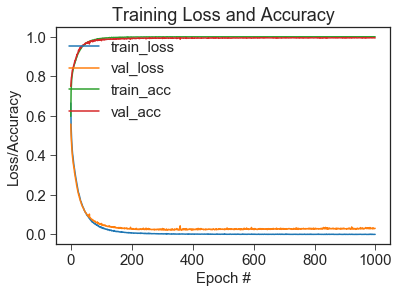

In [32]:
plt.style.use("seaborn-ticks")

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")